In [1]:
import os
import sys
sys.path.append('/home/royhirsch/conformal/')

from ml_collections import config_dict
import logging
import pandas as pd
import pickle
import torch
import torch.nn as nn

from conformal import get_conformal_module, get_percentile, clip_scores, calibrate_residual
from conformal_baselines import calc_baseline_mets
from data import get_dataloaders
from model import NN
from trainer import Trainer, get_optimizer, get_scheduler
from config import get_config_by_name
import utils as utils


def predict_and_report_mets(conformal_module, trainer, model, dl, fold_name=''):
    predict_out = trainer.predict(model, dl)

    if conformal_module.score_clip_value:
        predict_out['pred_scores'] = clip_scores(
            predict_out['pred_scores'],
            conformal_module.score_clip_value)

    sets = conformal_module.get_sets(predict_out['pred_scores'], predict_out['cls_probs'])
    mets = conformal_module.get_conformal_mets(sets, predict_out['cls_labels'])
    utils.log(f'{fold_name} mets', mets)
    return predict_out, mets

In [2]:
config = get_config_by_name('tissuemnist')
# config.alpha = 0.05
config.use_score_clipping = False # todo

utils.seed_everything(config.seed)
utils.create_logger(config.exp_dir, config.dump_log)

logging.info('Config:')
for k, v in config.items():
    logging.info(f'{k}: {v}')
logging.info('')

conformal_module = get_conformal_module(config.conformal_module_name)
dls, t = get_dataloaders(config, conformal_module)
train_dl = dls['train']
valid_dl = dls['valid']
test_dl = dls['test']
baseline_mets = calc_baseline_mets(train_dl, valid_dl, alpha=config.alpha, k_raps=config.k_raps)

# if use clipping, need to re-calc the scores for the datasets
if config.use_score_clipping:
    qhat = get_percentile(train_dl.dataset.scores, config.alpha)

    conformal_module.set_score_clipping(qhat)
    train_dl.dataset.scores = clip_scores(
        train_dl.dataset.scores, qhat)
    valid_dl.dataset.scores = clip_scores(
        valid_dl.dataset.scores, qhat)
    test_dl.dataset.scores = clip_scores(
        test_dl.dataset.scores, qhat)

    sets = conformal_module.get_sets(
        test_dl.dataset.scores.numpy(),
        test_dl.dataset.cls_probs.numpy())
    mets = conformal_module.get_conformal_mets(
        sets, test_dl.dataset.cls_labels.numpy())
    utils.log('Baseline mets (after clipping)', mets)


model = NN(input_dim=config.input_dim,
            hidden_dim=config.hidden_dim,
            norm=config.norm,
            drop_rate=config.drop_rate,
            criteria_name=config.criteria_name)
model = model.to(config.device)
logging.info(model)

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

if config.criteria_name == 'mse':
    criteria = nn.MSELoss()
elif config.criteria_name == 'bce':
    criteria = nn.BCELoss()
else:
    raise ValueError(f'Invalid loss name {config.criteria_name}')

trainer = Trainer(criteria=criteria,
                    metric_logger=utils.RegressionMetricLogger,
                    config=config)

trainer.fit(model=model,
            train_loader=train_dl,
            test_loader=valid_dl,
            optimizer=optimizer,
            scheduler=scheduler,
            valid_loader=valid_dl)

INFO - 11/04/23 14:03:13 - 0:00:00 - Created main log at tmp/net_launcher_log.log
INFO - 11/04/23 14:03:13 - 0:00:00 - Config:
INFO - 11/04/23 14:03:13 - 0:00:00 - alpha: 0.1
INFO - 11/04/23 14:03:13 - 0:00:00 - batch_size: 128
INFO - 11/04/23 14:03:13 - 0:00:00 - comments: 
INFO - 11/04/23 14:03:13 - 0:00:00 - conformal_module_name: aps
INFO - 11/04/23 14:03:13 - 0:00:00 - criteria_name: mse
INFO - 11/04/23 14:03:13 - 0:00:00 - dataset_name: tissuemnist
INFO - 11/04/23 14:03:13 - 0:00:00 - device: cuda:0
INFO - 11/04/23 14:03:13 - 0:00:00 - drop_rate: 0.0
INFO - 11/04/23 14:03:13 - 0:00:00 - dump_log: False
INFO - 11/04/23 14:03:13 - 0:00:00 - exp_dir: tmp
INFO - 11/04/23 14:03:13 - 0:00:00 - file_name: /home/royhirsch/conformal/data/embeds_n_logits/aug/medmnist/tissuemnist_test.pickle
INFO - 11/04/23 14:03:13 - 0:00:00 - gpu_num: 0
INFO - 11/04/23 14:03:13 - 0:00:00 - hidden_dim: 512
INFO - 11/04/23 14:03:13 - 0:00:00 - input_dim: 2048
INFO - 11/04/23 14:03:13 - 0:00:00 - k_raps: 5
I

In [3]:
# predict regression results for the trained model
# 0.9863331
conformal_module.score_clip_value = 0.99
train_predict_out, train_mets = predict_and_report_mets(
    conformal_module, trainer, model, train_dl, fold_name='Train')

val_predict_out, val_mets = predict_and_report_mets(
    conformal_module, trainer, model, valid_dl, fold_name='Valid')

test_predict_out, test_mets = predict_and_report_mets(
    conformal_module, trainer, model, test_dl, fold_name='Test')

INFO - 11/04/23 14:05:07 - 0:01:54 - Clipping 7.36% of the scores to 0.9900
INFO - 11/04/23 14:05:08 - 0:01:55 - Train mets: size_mean: 1.786 | size_std: 0.951 | acc: 0.847
INFO - 11/04/23 14:05:08 - 0:01:55 - Clipping 8.12% of the scores to 0.9900
INFO - 11/04/23 14:05:08 - 0:01:55 - Valid mets: size_mean: 1.752 | size_std: 0.895 | acc: 0.783
INFO - 11/04/23 14:05:08 - 0:01:55 - Clipping 8.78% of the scores to 0.9900
INFO - 11/04/23 14:05:08 - 0:01:55 - Test mets: size_mean: 1.710 | size_std: 0.893 | acc: 0.770


In [4]:
import numpy as np
import copy


def sigmoid(x):
    return 1. / (1 + np.exp(-x))


def calibrate_residual(calib_true_scores, calib_pred_scores, 
                       valid_true_scores, valid_pred_scores, 
                       calib_cls_probs,
                       valid_cls_probs,
                       alpha, 
                       method_name='add'):

    # get the quantile from the residuals
    if method_name == 'add':
        diff = calib_true_scores - calib_pred_scores
    elif method_name == 'power':
        max_cls_probs = calib_cls_probs.max(1)
        calib_pred_scores = np.asanyarray(calib_pred_scores)
        calib_pred_scores = np.minimum(np.maximum(calib_pred_scores, max_cls_probs), 1)

        diff = np.log(np.asarray(calib_pred_scores)) / np.log(np.asarray(calib_true_scores))
    elif method_name == 'sigmoid':
        diff = -np.asarray(calib_true_scores) - np.log(1. / np.asarray(calib_pred_scores) - 1)
    elif method_name == 'jacob':
        max_cls_probs = calib_cls_probs.max(1)
        calib_pred_scores = np.asanyarray(calib_pred_scores)
        calib_pred_scores = np.minimum(np.maximum(calib_pred_scores, max_cls_probs), 1)
        diff = calib_true_scores - calib_pred_scores
    elif method_name == 'jacob2':
        calib_pred_scores = np.asarray(calib_pred_scores)
        calib_pred_scores = np.clip(calib_pred_scores, a_min=0.01, a_max=0.99)
        diff = (calib_true_scores - calib_pred_scores) / (1. - calib_pred_scores)
    else:
        raise ValueError

    n = len(diff)
    qhat = np.quantile(
        diff, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")

    # modify the validation scores
    if method_name == 'add':
        modified_valid_pred_scores = copy.deepcopy(valid_pred_scores) + qhat
    elif method_name == 'power':
        max_cls_probs = valid_cls_probs.max(1)
        valid_pred_scores = np.asanyarray(valid_pred_scores)
        valid_pred_scores = np.minimum(np.maximum(valid_pred_scores, max_cls_probs), 1)
        modified_valid_pred_scores = np.power(copy.deepcopy(valid_pred_scores), 1. / qhat)
    elif method_name == 'sigmoid':
        modified_valid_pred_scores = sigmoid(copy.deepcopy(valid_pred_scores) + qhat)
    elif method_name == 'jacob':
        max_cls_probs = valid_cls_probs.max(1)
        valid_pred_scores = np.asanyarray(valid_pred_scores)
        valid_pred_scores = np.minimum(np.maximum(valid_pred_scores, max_cls_probs), 1)
        modified_valid_pred_scores = copy.deepcopy(valid_pred_scores) + qhat
    elif method_name == 'jacob2':
        valid_pred_scores = np.asarray(valid_pred_scores)
        valid_pred_scores = np.clip(valid_pred_scores, a_min=0.01, a_max=0.99)
        modified_valid_pred_scores = valid_pred_scores + qhat * (1. - valid_pred_scores)
    else:
        raise ValueError

    n_over_one = (modified_valid_pred_scores >= 1.).sum() / len(modified_valid_pred_scores)
    logging.info('Residuals correction is {:.3f}, clip {:.2f}% of the samples'.format(
        qhat, n_over_one * 100.))

    if n_over_one:
        modified_valid_pred_scores = np.minimum(modified_valid_pred_scores, 0.9)

    return modified_valid_pred_scores, qhat



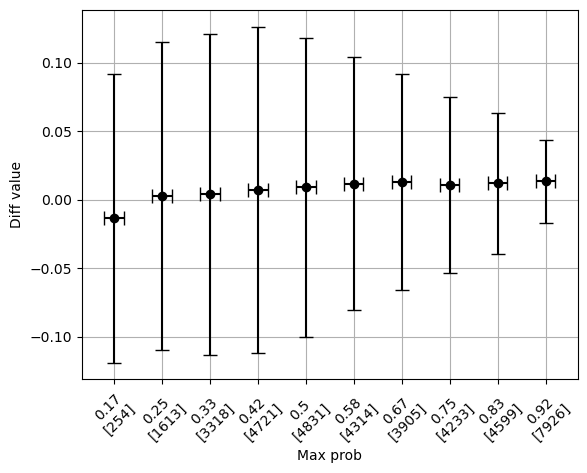

In [5]:
import matplotlib.pyplot as plt
import copy

def scatter(x, y):
    plt.scatter(x, y, alpha = 0.1)
    plt.plot([0,1], [0,1], color="red")
    r2 = utils.calc_r2(x, y)
    plt.text(0.1, 0.9, f"R^2 = {r2:.3f}", transform=plt.gca().transAxes, fontsize=14)
    plt.show()

calib_true_scores = copy.deepcopy(train_predict_out['true_scores'])
calib_pred_scores = copy.deepcopy(train_predict_out['pred_scores'])
calib_probs = copy.deepcopy(train_predict_out['cls_probs'])
calib_labels = copy.deepcopy(train_predict_out['cls_labels'])

valid_pred_scores = copy.deepcopy(test_predict_out['pred_scores'])

diff = calib_true_scores - calib_pred_scores

num_bins = 10

# x = []
# for i, s in enumerate(calib_labels):
#     x.append(calib_probs[i, s])
x = np.asarray(calib_probs.max(1))

x_title = 'Max prob'
y = diff

histogram, bin_edges = np.histogram(x, bins=num_bins)
indices_dict = {bin_index: [] for bin_index in range(num_bins)}

for i, value in enumerate(x):
    bin_index = np.digitize(value, bin_edges) - 1
    if bin_index < num_bins:
        indices_dict[bin_index].append(i)

bines_values = [y[np.asarray(v)] for v in indices_dict.values()]
y_means = [np.mean(m) for m in bines_values]
y_sizes = [len(m) for m in bines_values]
y_errors = [np.std(m) for m in bines_values]

fig, ax = plt.subplots()
# ax.boxplot(y_means, positions=np.arange(num_bins), widths=0.4, vert=False)
ax.errorbar(np.arange(num_bins), y_means, xerr=0.2, yerr=y_errors, linestyle='None', color='black', capsize=5, marker='o')

_ = plt.xticks(np.arange(num_bins), [f'{n:.2}\n[{m}]' for n, m in zip(np.round(bin_edges[:-1], 3), y_sizes)], rotation=45)
plt.ylabel('Diff value')
plt.xlabel(x_title)
plt.grid(True)

Text(0.5, 1.0, 'The residuals ${r_t}$ standard deviations')

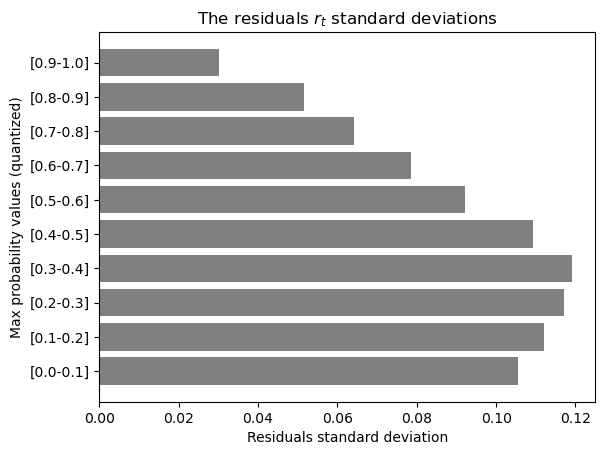

In [11]:
plt.barh(np.arange(num_bins), y_errors, color='grey')
_ = plt.yticks(np.arange(num_bins), [f'[{i/num_bins}-{(i+1)/num_bins}]' for i in np.arange(num_bins)])
plt.xlabel('Residuals standard deviation')
plt.ylabel('Max probability values (quantized)')
plt.title(r'The residuals ${r_t}$ standard deviations')


In [7]:
import matplotlib.pyplot as plt
import copy


def divide(probs, alpha=config.alpha):
    below_indxs = np.where(probs < (1. - alpha))[0]
    above_indxs = np.where(probs >= (1. - alpha))[0]
    return below_indxs, above_indxs


def calc_correction_bias(diff, alpha=config.alpha):
    n = len(diff)
    qhat = np.quantile(
        diff, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")
    return qhat


calib_true_scores = copy.deepcopy(train_predict_out['true_scores'])
calib_pred_scores = copy.deepcopy(train_predict_out['pred_scores'])
calib_probs = copy.deepcopy(train_predict_out['cls_probs']).max(1)

valid_pred_scores = copy.deepcopy(test_predict_out['pred_scores'])
valid_probs = copy.deepcopy(test_predict_out['cls_probs']).max(1)

calib_pred_scores = np.asarray(calib_pred_scores)
calib_pred_scores = np.clip(calib_pred_scores, a_min=0.01, a_max=0.99)

diff = calib_true_scores - calib_pred_scores

calib_below_indxs, calib_above_indxs = divide(calib_probs)
qhat_below = calc_correction_bias(diff[calib_below_indxs])
qhat_above = calc_correction_bias(diff[calib_above_indxs])
print(qhat_below, qhat_above)

valid_pred_scores = np.asarray(valid_pred_scores)
valid_pred_scores = np.clip(valid_pred_scores, a_min=0.01, a_max=0.99)

modified_valid_pred_scores = []
for v, s in zip(valid_pred_scores, valid_probs):
    if s < (1. - config.alpha):
        modified_valid_pred_scores.append(v + qhat_below)
    else:
        modified_valid_pred_scores.append(v + qhat_above)

modified_valid_pred_scores = np.asarray(modified_valid_pred_scores)
modified_valid_pred_scores = np.clip(modified_valid_pred_scores, a_min=0.01, a_max=1 - config.alpha)
calibrated_test_pred_scores = modified_valid_pred_scores

conformal_module = get_conformal_module(config.conformal_module_name)
sets = conformal_module.get_sets(calibrated_test_pred_scores,
                                 test_predict_out['cls_probs'])
calibrated_test_mets = conformal_module.get_conformal_mets(
    sets, test_predict_out['cls_labels'])
utils.log('Calibrated test mets', calibrated_test_mets)

baseline_mets['cp_net'] = test_mets
baseline_mets['cp_net_post'] = calibrated_test_mets
pd.DataFrame(baseline_mets).T


/tmp/ipykernel_39003/620542118.py:13: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(
INFO - 11/04/23 14:05:09 - 0:01:56 - Calibrated test mets: size_mean: 2.174 | size_std: 0.942 | acc: 0.905


0.13366234 0.054698706


,size_mean,size_std,acc
naive,2.660497,1.314009,0.945796
aps,3.458752,1.816042,0.894765
aps_randomized,2.336594,1.224261,0.916446
raps,2.658382,1.310236,0.945796
raps_randomized,2.294553,1.234086,0.898731
cp_net,1.710471,0.893298,0.769963
cp_net_post,2.173718,0.942401,0.905077


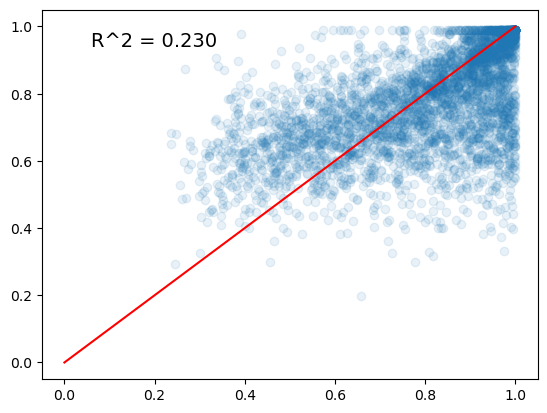

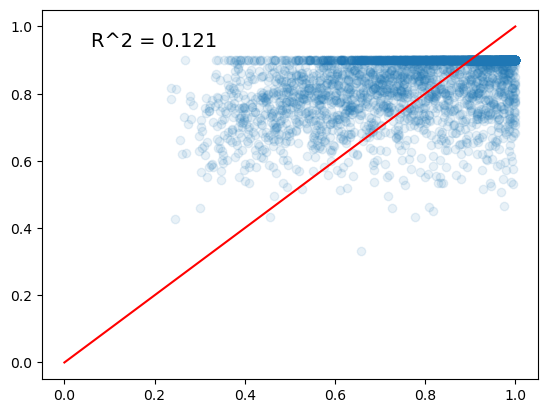

In [8]:
def scatter(x, y):
    plt.scatter(x, y, alpha = 0.1)
    plt.plot([0,1], [0,1], color="red")
    r2 = utils.calc_r2(x, y)
    plt.text(0.1, 0.9, f"R^2 = {r2:.3f}", transform=plt.gca().transAxes, fontsize=14)
    plt.show()

scatter(test_predict_out['true_scores'], valid_pred_scores)
scatter(test_predict_out['true_scores'], modified_valid_pred_scores)

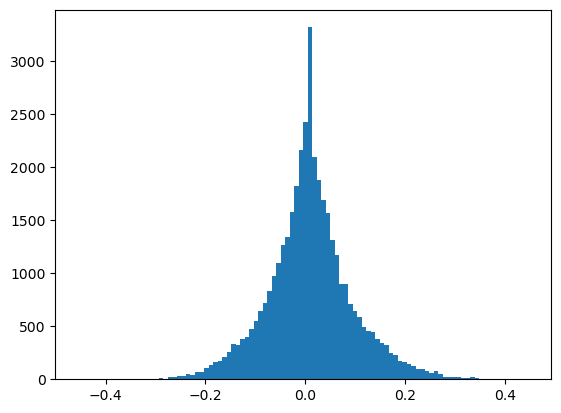

In [9]:
import matplotlib.pyplot as plt
_ = plt.hist(diff, bins=100)

In [10]:
# calibrate the predicted scores
calibrated_test_pred_scores = modified_valid_pred_scores

# calibrated_test_pred_scores, qhat = calibrate_residual(
#     train_predict_out['true_scores'], # todo
#     train_predict_out['pred_scores'],
#     test_predict_out['true_scores'],
#     test_predict_out['pred_scores'], 
#     train_predict_out['cls_probs'],
#     test_predict_out['cls_probs'],
#     config.alpha,
#     'jacob2')

conformal_module = get_conformal_module(config.conformal_module_name)
sets = conformal_module.get_sets(calibrated_test_pred_scores,
                                 test_predict_out['cls_probs'])
calibrated_test_mets = conformal_module.get_conformal_mets(
    sets, test_predict_out['cls_labels'])
utils.log('Calibrated test mets', calibrated_test_mets)

baseline_mets['cp_net'] = test_mets
baseline_mets['cp_net_post'] = calibrated_test_mets
df_mets = pd.DataFrame(baseline_mets).T
logging.info(df_mets)
if config.dump_log:
    df_mets.to_csv(os.path.join(config.exp_dir, 'results.csv'))

calibrated_test_mets['qhat'] = qhat


INFO - 11/04/23 14:05:09 - 0:01:57 - Calibrated test mets: size_mean: 2.174 | size_std: 0.942 | acc: 0.905
INFO - 11/04/23 14:05:09 - 0:01:57 -                  size_mean  size_std       acc
                                     naive             2.660497  1.314009  0.945796
                                     aps               3.458752  1.816042  0.894765
                                     aps_randomized    2.336594  1.224261  0.916446
                                     raps              2.658382  1.310236  0.945796
                                     raps_randomized   2.294553  1.234086  0.898731
                                     cp_net            1.710471  0.893298  0.769963
                                     cp_net_post       2.173718  0.942401  0.905077


NameError: name 'qhat' is not defined

In [ ]:
0.9 - 0.76

0.14

(array([  1.,   8.,  40., 117., 301., 569., 656., 644., 581., 865.]),
 array([0.81456792, 0.83287984, 0.85119176, 0.86950374, 0.88781565,
        0.90612757, 0.92443949, 0.94275141, 0.96106339, 0.9793753 ,
        0.99768722]),
 <BarContainer object of 10 artists>)

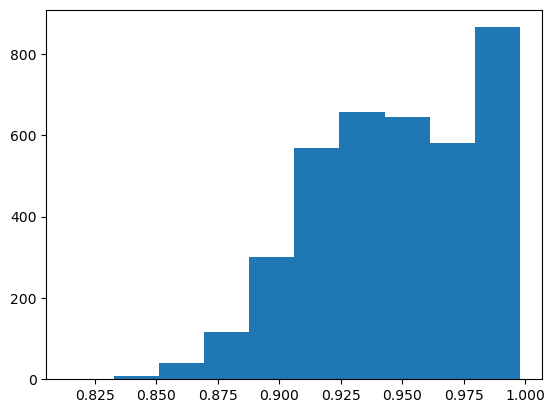

In [ ]:
import matplotlib.pyplot as plt
plt.hist(calibrated_test_pred_scores)

Text(0, 0.5, 'MSE Loss')

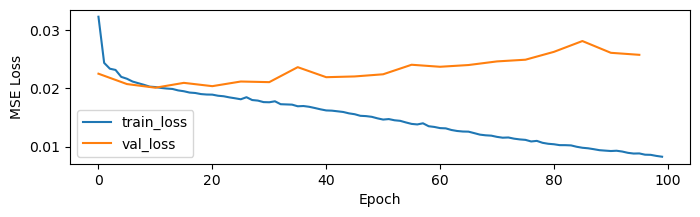

In [ ]:
history = trainer.history
plt.figure(figsize=(8, 2))
plt.plot(np.arange(len(history['loss'])), history['loss'], label='train_loss')
plt.plot( np.arange(0, len(history['loss']), config.val_interval), history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

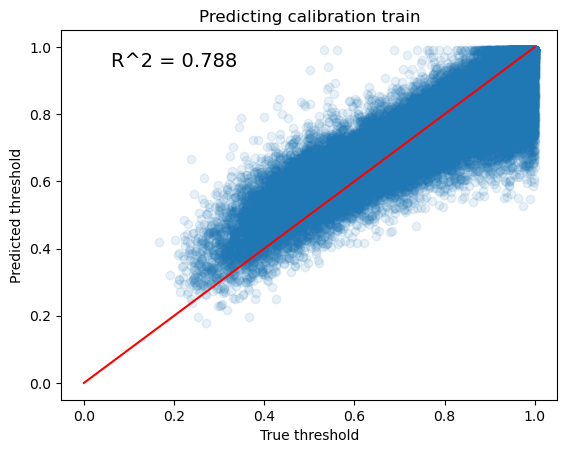

In [ ]:
# outputs = val_outputs
o = train_predict_out
eps = 1
plt.scatter(o['true_scores'], o['pred_scores'] ** eps, alpha = 0.1)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("True threshold")
plt.ylabel("Predicted threshold")

r2 = utils.calc_r2(o['true_scores'], o['pred_scores'] ** eps)

plt.text(0.1, 0.9, f"R^2 = {r2:.3f}", transform=plt.gca().transAxes, fontsize=14)
plt.title("Predicting calibration train")
plt.show()

In [ ]:
len(m)


NameError: name 'm' is not defined

In [ ]:
diff = o['true_scores'] - o['pred_scores']
_, edges = np.histogram(o['pred_scores'], bins=10)
inds = np.digitize(o['pred_scores'], bins=edges)

bin2diff = {i:[] for i in np.unique(inds)}
for i in np.unique(inds):
    bin2diff[i] = diff[inds == i]
m = [v.mean() for v in bin2diff.values()]
s = [v.std() for v in bin2diff.values()]
plt.errorbar(np.arange(11), y=m, yerr=s)


In [ ]:
edges

In [ ]:
len(np.unique(inds)), len(edges[1:])

In [ ]:
diff = o['true_scores'] - o['pred_scores']
counts, edges = np.histogram(o['true_scores'], bins=10)
inds = np.digitize(o['true_scores'], bins=edges[2:])

bin2diff = {}
for i in np.unique(inds):
    bin2diff[i] = diff[inds == i]
m = [v.mean() for v in bin2diff.values()]
s = [v.std() for v in bin2diff.values()]
x = np.arange(10)
plt.figure(figsize=[15,5])
plt.errorbar(x, m, yerr=s, fmt='o', color='b', label='')
for i, (xi, yi, err) in enumerate(zip(x, m, s)):
    _ = plt.gca().add_patch(plt.Rectangle((xi - 0.4, yi - err), 0.8, 2 * err, fill=None, color='orange', linestyle='dashed'))
custom_xticks = [f'[{a/10}-{(a+1)/10}]\n[{b}]' for a, b in zip(x,  [len(v) for v in bin2diff.values()])]
plt.grid(True)
plt.xticks(x, custom_xticks, rotation=0)  # Set custom xticks
plt.ylabel('Diff mean and std')
plt.xlabel('True score bin')
